In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import copy
import colorspacious as cs

In [2]:
measurments = pd.read_csv("data/LabMeasurements-Color-Card.csv", decimal=',', sep=';')
master_colors = pd.read_csv("data/MasterColorCard.csv", decimal=',', sep=';')

# make multilevel index for measurments columns
row = measurments['Row']
col = measurments['Column']
measurments = measurments.drop(['Row', 'Column'], axis=1)
new_cols = pd.MultiIndex.from_tuples(
    [(int(col[1:]), col[0]) for col in measurments.columns]
)
measurments.columns = new_cols
measurments.insert(0, 'Row', row)
measurments.insert(1, 'Column', col)

# make multilevel index for master color rows
master_colors.set_index(['Crow', 'Ccol'], inplace=True)

In [4]:
def delta_e(L, a, b, L_m, a_m, b_m):
    return np.sqrt( (L-L_m)**2 + (a-a_m)**2 + (b-b_m)**2)

In [11]:
# compute delta e values
delta_e_values = np.zeros((546, 64))

min_error = 0
max_error = 0

for i in range(546):
    j = 0
    for row in range(1,9):
        for col in range(1,9):
            spot = row*10+col
            L_master = master_colors.loc[row, col]['L']
            a_master = master_colors.loc[row, col]['a']
            b_master = master_colors.loc[row, col]['b']

            L = measurments.loc[i, (spot, 'L')]
            a = measurments.loc[i, (spot, 'a')]
            b = measurments.loc[i, (spot, 'b')]

            delta_e_values[i, j] = delta_e(L, a, b, L_master, a_master, b_master)
            j += 1

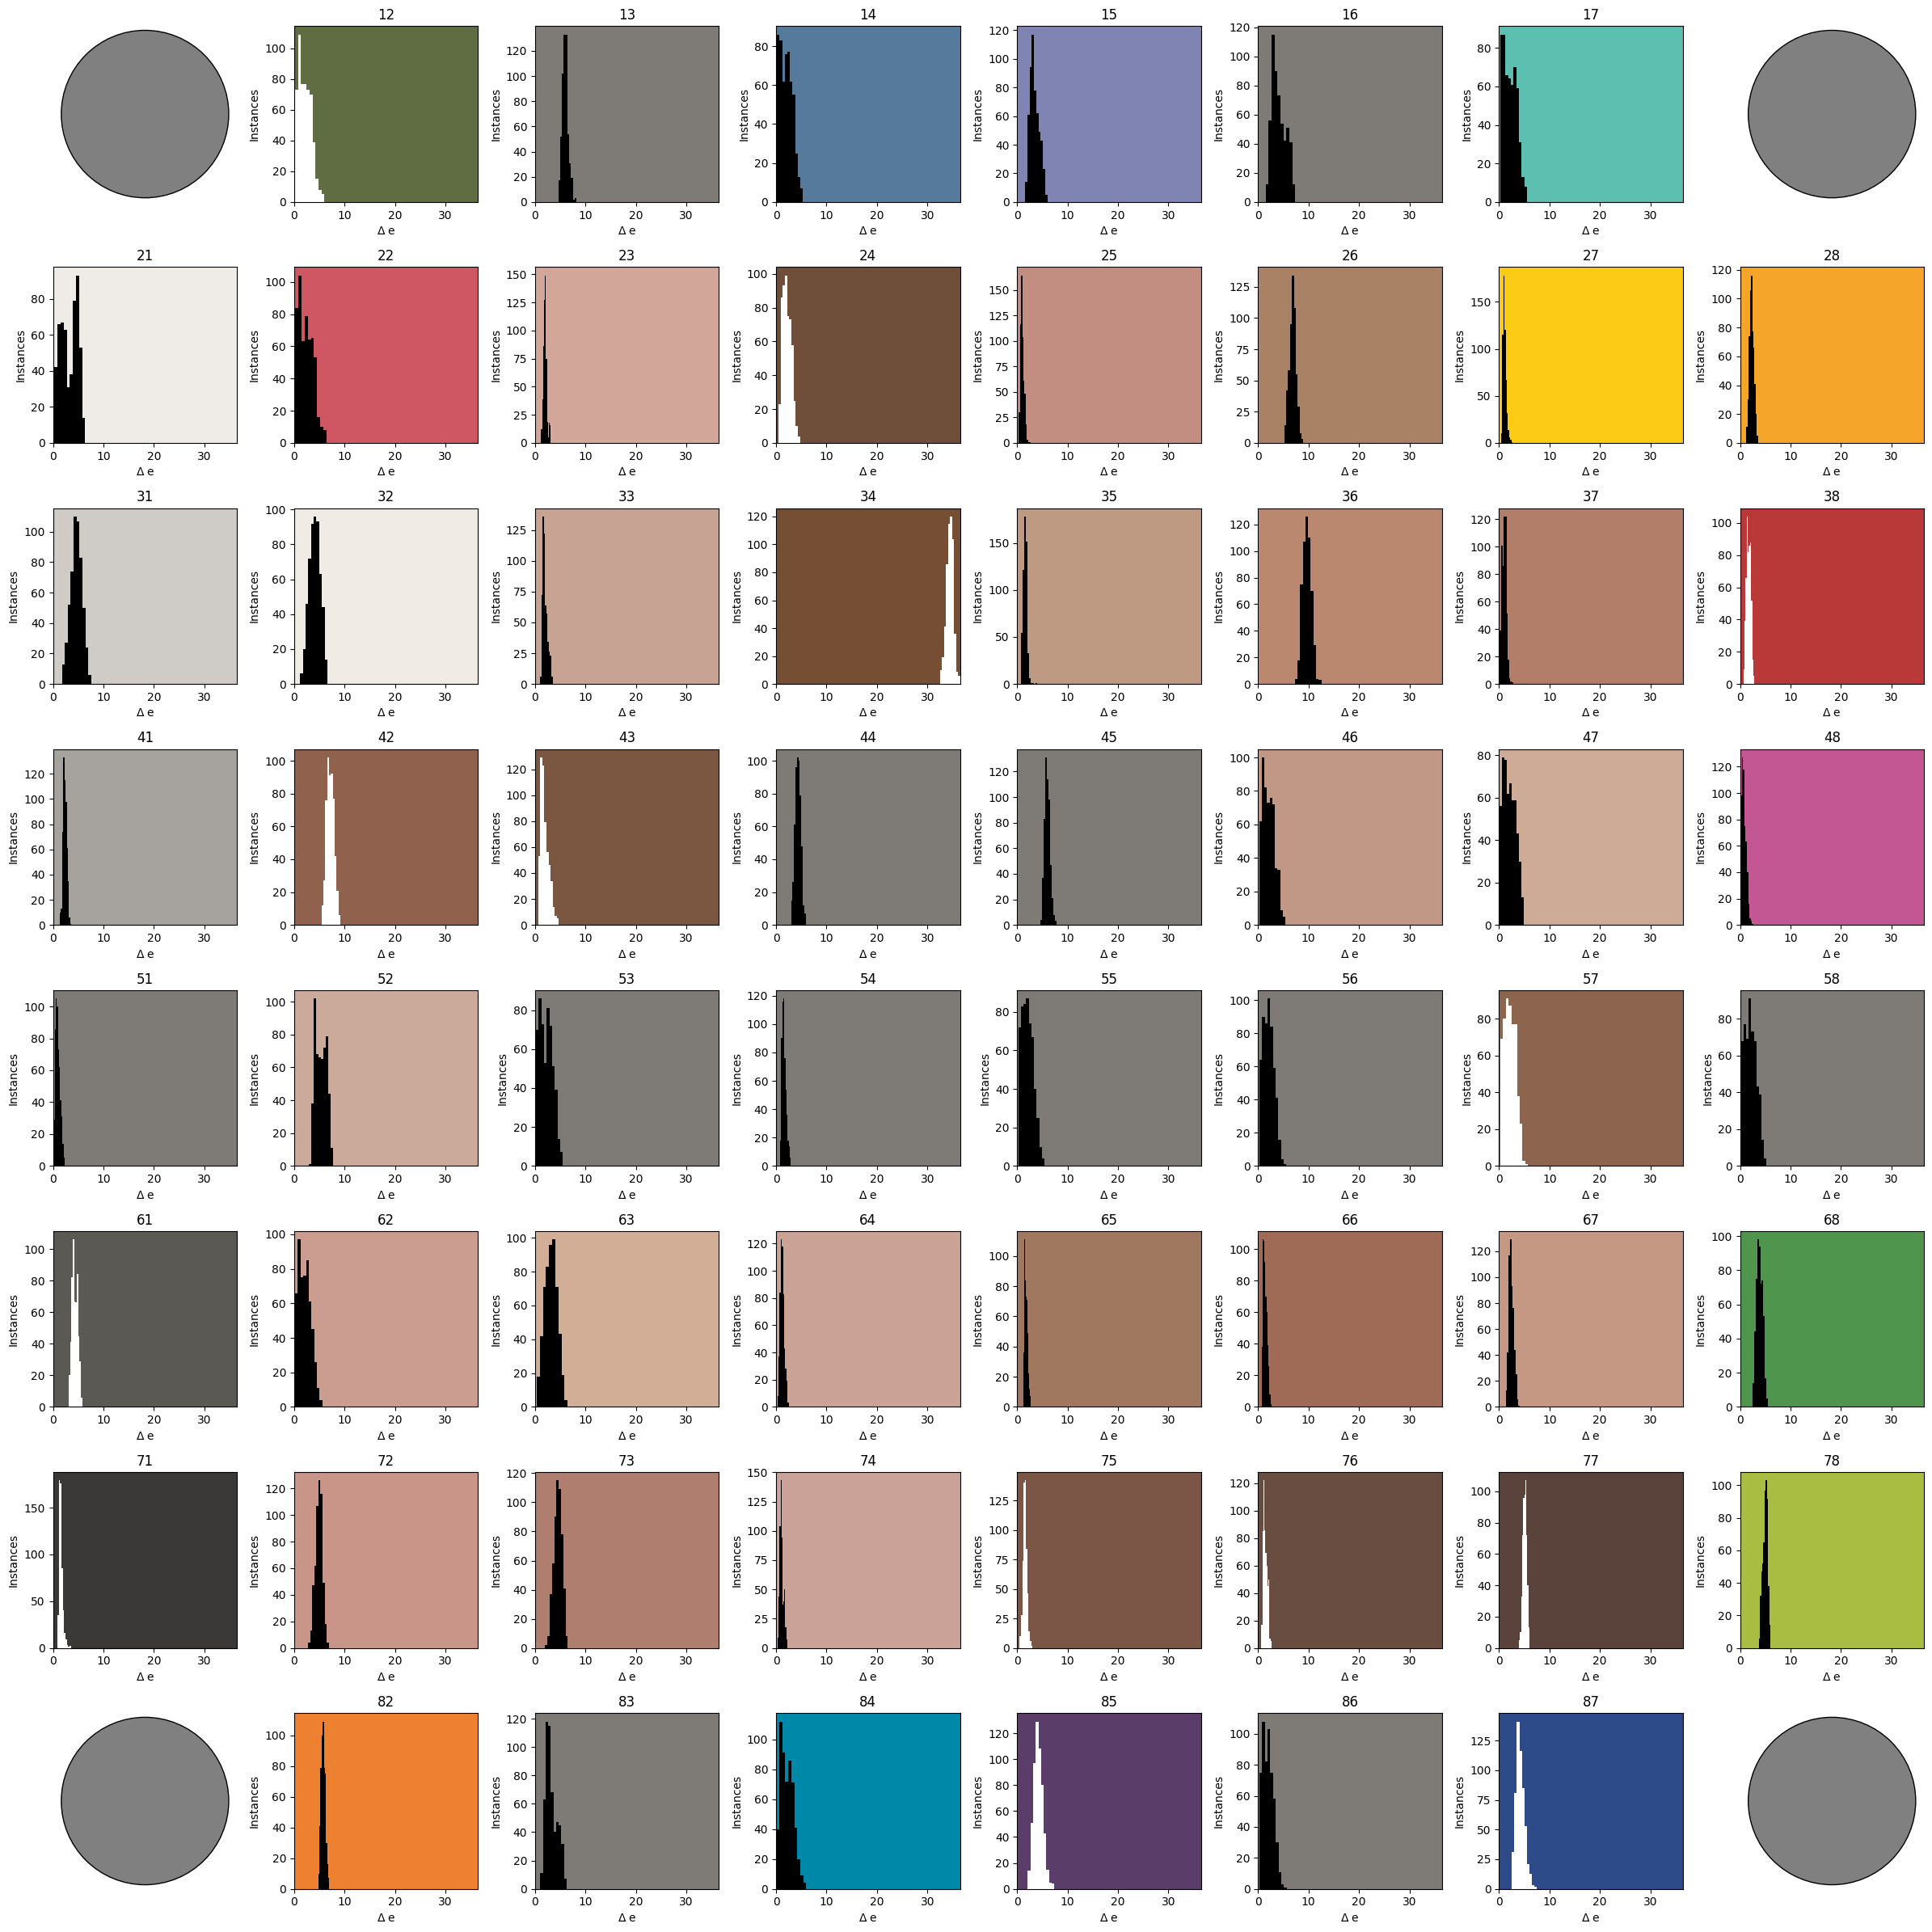

In [40]:
fig, axes = plt.subplots(8,8, figsize=(24,24))

max_error = np.max(delta_e_values)

j = 0
for row in range(1,9):
    for col in range(1,9):
        ax = axes[row-1, col-1]
        spot = row*10+col

        if spot in [11, 18, 81, 88]:
            circle = patches.Circle((0.0, 0.0), 10, facecolor='gray', edgecolor='black')
            ax.add_patch(circle)
            ax.set_aspect('equal')
            ax.set_xlim([-10.5,10.5])
            ax.set_ylim([-10.5,10.5])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        L_master = master_colors.loc[row, col]['L']
        a_master = master_colors.loc[row, col]['a']
        b_master = master_colors.loc[row, col]['b']
        master_color = cs.cspace_convert([L_master, a_master, b_master], "CIELab", "sRGB1")
        master_color = np.clip(master_color, 0, 1)
        ax.set_facecolor(master_color)

        hist_color = 'white' if L_master < 47 else 'black'
        ax.hist(delta_e_values[:, j], color=hist_color)

        ax.set_xlim([0, max_error])
        ax.set_ylabel('Instances')
        ax.set_xlabel(r'$\Delta$ e')
        ax.set_title(str(spot))
        j += 1

plt.tight_layout()
plt.savefig('figures/delta_e_hists.png')